In [1]:
%matplotlib notebook

import pickle as pkl
import numpy as np
import scipy as sc
import sncosmo
from matplotlib import pyplot as plt

In [2]:
def plot_wrms_residuals(residuals, phase, filters=[ 'cspg', 'cspb',  'cspv', 'cspr', 'cspi'], figsize=(10,15), 
                    xlim=(-5,45), lim_res=(0.0,0.1), path_file=None, model_used='sugar'):
        mean = {}
        std = {}
        results = {}
        plt.figure(figsize=figsize)
        results = {}  
        
        for   band in filters:
            mean[band] = {'mean_value':[], 'err_mean':[]}
            std[band] = {'std_value':[], 'err_std':[], 'wrms_value':[],
                               'wrms_err':[]}
            results[band] = {'res_bin_phase':{} , 'var_bin_phase' : {}}
            p = []
            for i in range(len(phase)-1):
                results[band]['res_bin_phase'][str(phase[i])+'_'+str(phase[i+1])] = []
                results[band]['var_bin_phase'][str(phase[i])+'_'+str(phase[i+1])] = []
                p.append((phase[i+1]+phase[i])/2)
                    
        for sn in residuals.keys():
            for   band in filters:
                if band in residuals[sn]['data'].keys():
                    for n, t in enumerate(residuals[sn]['data'][band]['phase']):
                        for i in range(len(phase)-1):
                            if t >= phase[i] and t < phase[i+1]: 
                                results[band]['res_bin_phase'][str(phase[i])+'_'+str(phase[i+1])].append(residuals[sn]['data'][band]['residual'][n])
                                results[band]['var_bin_phase'][str(phase[i])+'_'+str(phase[i+1])].append(residuals[sn]['data'][band]['err_mag'][n])


        for  j,  band in enumerate(filters):
                for i in range(len(phase)-1):
                    res_phase = np.array(results[band]['res_bin_phase'][str(phase[i])+'_'+str(phase[i+1])])
                    var_phase = np.array(results[band]['var_bin_phase'][str(phase[i])+'_'+str(phase[i+1])])
                    err_mean = np.std(res_phase)/np.sqrt(len(res_phase)-1)
                    err_std = np.std(res_phase)/np.sqrt(2*len(res_phase))
                    mean[band]['mean_value'].append(np.mean(res_phase))
                    std[band]['std_value'].append(np.std(res_phase))
                    wrms = np.float(np.sqrt(np.sum(res_phase**2/var_phase**2)/np.sum(1/var_phase**2)))
                    std[band]['wrms_value'].append(wrms)
                    std[band]['wrms_err'].append( np.sqrt(wrms*2*len(res_phase)/(2*np.sum(1/var_phase**2))))
                    mean[band]['err_mean'].append(err_mean)
                    std[band]['err_std'].append(err_std)
                plt.subplot(len(filters)*2, 2, 2*j+1)

                plt.errorbar(p, mean[band]['mean_value'], yerr=mean[band]['err_mean'], label=model_used)
                plt.plot([-15.,50.],[0.,0.], color='black')
                plt.ylabel('$\Delta$ '+band)
                plt.xlim(xlim)

                if j == 0:

                    plt.title('Moyenne des résidus')
                if j == len(filters)-1:
                    plt.xlabel('phase')
                    plt.legend()    
                plt.subplot(len(filters)*2, 2, 2*(j+1))
                plt.errorbar(p, std[band]['wrms_value'], yerr=std[band]['wrms_err'],  label=model_used)   
                plt.ylim(lim_res)             
                plt.xlim(xlim)
                if j == 0:
                    plt.title('wRMS des résidus')
        #                plt.legend()
                if j == len(filters)-1:
                    plt.xlabel('phase')
                    plt.legend()    
        if path_file != None:
                plt.savefig(path_file, bbox_inches='tight') 
        plt.show()
        plt.close()

### End of Florian's header

In [3]:
file = open('csp_errmod_res.pkl','rb')
data = pkl.load(file)

In [4]:
%matplotlib inline

In [5]:
data['SN2004gc_snpy.txt']['data']['cspg'].keys()

dict_keys(['residual', 'phase', 'err_mag'])

In [6]:
np.array(data['SN2004gc_snpy.txt']['data']['cspg']['phase'])

array([ 1.77408337,  2.69453681,  3.64405721,  4.60326659,  5.61092088,
        8.48854902,  9.47682535, 12.36414247, 13.33304083, 16.23004694,
       17.18925632, 20.15408531, 21.11329468, 23.96185587, 24.8919983 ,
       27.86651627, 28.76759175, 32.63349621, 40.41375007, 43.32044515,
       44.27965453, 47.1960386 ])

#### flatten the phases

In [7]:
# general defs
filters=[ 'cspb', 'cspg',  'cspv', 'cspr', 'cspi']
filt_cols={'cspb':'b','cspg':'c','cspv':'g','cspr':'r','cspi':'#7f7f7f'}
filt_wlength={'cspb':4405.52523158631,'cspg':4794.041505636825,'cspv':5389.265240884614,'cspr':6239.341129133972,'cspi':7630.7634178811795}

In [8]:
#filters=[ 'cspg', 'cspb',  'cspv', 'cspr', 'cspi']
flat_data=dict()
for filt in filters:
    flat_data[filt]={'residual':[],'phase':[],'err_mag':[]}
    for sn in data:
        for k in data[sn]['data'][filt]:
            flat_data[filt][k] += data[sn]['data'][filt][k]
    # and not, sort in time
    idx = np.argsort(flat_data[filt]['phase'])
    flat_data[filt]['residual']=np.array(flat_data[filt]['residual'])[idx]
    flat_data[filt]['err_mag']=np.array(flat_data[filt]['err_mag'])[idx]
    flat_data[filt]['phase']=np.array(flat_data[filt]['phase'])[idx]
        

In [9]:
def plot_data(data,filters=[ 'cspb', 'cspg',  'cspv', 'cspr', 'cspi']):
    for i,filt in enumerate(filters):
        #plt.figure(figsize=(6,4))
        plt.subplot(len(filters), 1, i+1)
        plt.errorbar(data[filt]['phase'],data[filt]['residual'],yerr=data[filt]['err_mag'],fmt='.',color=filt_cols[filt])
        plt.xlabel('Phase')
        plt.ylabel(filt + ' (mag)')

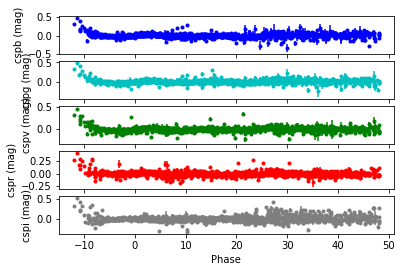

In [10]:
plot_data(flat_data)

(array([ 47., 139., 172., 163., 136., 124., 138., 125.,  93.,  81.]),
 array([-1.19998872e+01, -5.99989883e+00,  8.95199849e-05,  6.00007787e+00,
         1.20000662e+01,  1.80000546e+01,  2.40000429e+01,  3.00000313e+01,
         3.60000196e+01,  4.20000080e+01,  4.79999963e+01]),
 <a list of 10 Patch objects>)

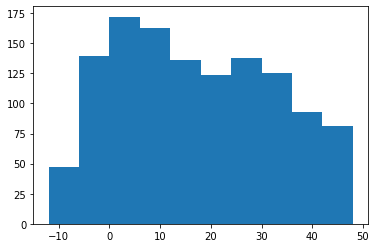

In [11]:
plt.figure()
plt.hist(flat_data['cspr']['phase'])


#### Testing a biautifoul spline

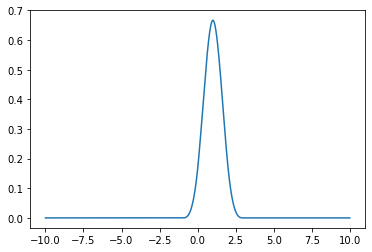

In [12]:
x = np.arange(-10,10,0.01)
y = sc.interpolate.splev(x,(np.array([-4.,-3,-2,-1,0,1,2,3,4,5,6]),np.array([0,0.,0,1.,0,0,0]),3),ext=1)
plt.figure()
plt.plot(x,y)

#### Spline on time data : the mean

In [13]:
# global parameters of SUGAR
tfirst_glob = -12
tlast_glob = 48

In [14]:
#singularise a band
spldata = flat_data["cspb"]

In [15]:
def make_B_matrix(phases,nknots,tfirst=tfirst_glob,tlast=tlast_glob,degree=3):
    """builds the matrix used to solve the spline fit
        this matrix doens't depend on the errors : this is the derivative of 
        spline coefficients projected at the phase of the data
        
        phases : phases of the data
        nknots : number of spline knots, starting at 1 for no internal knots"""
    
    deltat = (tlast-tfirst)/nknots
    xrefs = np.arange(tfirst-degree*deltat,tlast+(degree+1)*deltat,deltat)
    # OK, now, what would be the coefficients ?
    # B is a matrix of rank x=ndata y = nparams

    npars = nknots + degree # number of parameters is nknots + rank of spline
    B = np.zeros(( npars, len(phases) ) )
    # loop in all params in order to fill B

    ctest = np.zeros(npars)
    for itest in range(npars):
        ctest[itest]=1
        B[itest] = sc.interpolate.splev(phases,(xrefs, ctest,3))
        ctest[itest]=0
    return B,xrefs




In [16]:
class err_model_constant:
    def __init__(self,param=0):
        self.params=param
        
    def error(self, phase):
        return self.params

In [17]:
def make_spline_fit(res_data,nknots,err_model=err_model_constant()):
    B,xrefs = make_B_matrix(res_data['phase'],nknots)
    w = 1./ ( res_data['err_mag']**2 + err_model.error(res_data['phase'])**2)
    By = B.dot(res_data['residual'] * w)
    BB = (B * w ) .dot(B.T) # here the weights will take place
    cho = sc.linalg.cho_factor(BB)
    C = sc.linalg.cho_solve (cho,By)
    return C,xrefs

def get_spline_coef_covar(res_data,nknots,err_model=err_model_constant()):
    B,xrefs = make_B_matrix(res_data['phase'],nknots)
    w = 1./ ( res_data['err_mag']**2 + err_model.error(res_data['phase'])**2)
    #By = B.dot(res_data['residual'] * w)
    BB = (B * w ) .dot(B.T) # here the weights will take place
    #cho = sc.linalg.cho_factor(BB)
    #C = sc.linalg.cho_solve (cho,By)
    return np.linalg.inv(BB)

In [18]:
C,xrefs = make_spline_fit(spldata,10)

In [19]:
yspl = sc.interpolate.splev(spldata['phase'],(xrefs,C,3))
# a chi2 is handy !
np.sum((spldata['residual']-yspl)**2 / np.array(spldata['err_mag'])**2)

24800.189916389707

In [20]:
### crude error estimate
#wrms = np.float(np.sqrt(np.sum(res_phase**2/var_phase**2)/np.sum(1/var_phase**2)))
wrms = np.sqrt(np.sum((spldata['residual']-yspl)**2 / np.array(spldata['err_mag'])**2) \
    / np.sum(1./np.array(spldata['err_mag'])**2))
print (wrms)

0.04291276146222363


In [21]:
### and iterate
#err_model = err_model_constant(wrms_init['cspb'])
err_model = err_model_constant(wrms)
C,xrefs = make_spline_fit(spldata,10, err_model)
yspl = sc.interpolate.splev(spldata['phase'],(xrefs,C,3))
# a chi2 is handy !
np.sum((spldata['residual']-yspl)**2 / ( np.array(spldata['err_mag'])**2+err_model.params**2 ) )

1203.6838407973148

<ErrorbarContainer object of 3 artists>

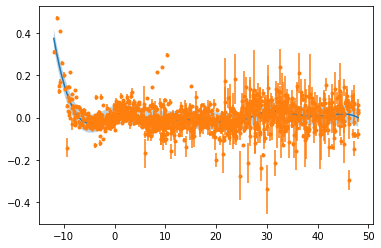

In [22]:
plt.figure()
plt.plot(spldata['phase'],yspl)
plt.fill_between(spldata['phase'],yspl+err_model.error(spldata['phase']),yspl-err_model.error(spldata['phase']),alpha=0.3)
#yerr = np.sqrt( np.array(spldata['err_mag'])**2+err_model.params**2 ) 
yerr = np.sqrt( np.array(spldata['err_mag'])**2 ) 
plt.errorbar(spldata['phase'],spldata['residual'],yerr = yerr, fmt='.')

### biccing this to get number of nodes

In [30]:
# we need a default error model : as wrms depends on fit quality... 
# then we can iterate once we will stabilize the number of nodes

In [31]:
def guess_wrms (res_data):
    wrms=dict()
    for filt in filters:
        wrms[filt] = np.sqrt(np.sum((res_data[filt]['residual'])**2 / np.array(res_data[filt]['err_mag'])**2) \
    / np.sum(1./np.array(res_data[filt]['err_mag'])**2))
    return wrms

In [32]:
wrms_init = guess_wrms(flat_data)

In [33]:
def compute_bic(res_data,nknots,error_guess=wrms_init):
    chi2 = 0
    ndf = 0
    bic=0
    for filt in filters:
        err_model = err_model_constant(error_guess[filt])
        C,xrefs = make_spline_fit(res_data[filt],nknots, err_model)
        yspl = sc.interpolate.splev(res_data[filt]['phase'],(xrefs,C,3))
        # return chi2... for now
        chi2 += np.sum((res_data[filt]['residual']-yspl)**2 / ( np.array(res_data[filt]['err_mag'])**2+err_model.params**2 ) )
        ndf += len(yspl)-(nknots+3)
        bic += (nknots+3) * np.log(len(yspl))
    return chi2, chi2+bic

In [34]:
bic=list()
for nknots in range(20):
    bic += [compute_bic(flat_data,nknots+1)[1]]

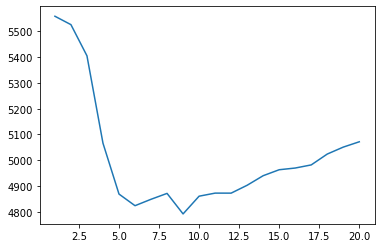

In [35]:
plt.figure()
plt.plot(np.arange(20)+1,bic)

#### OK, do it for 9 days, and guess the new wrms

In [36]:
def compute_wrms(res_data,nknots,errors):
    wrms=dict()
    for filt in filters:
        err_model = err_model_constant(errors[filt])
        C,xrefs = make_spline_fit(res_data[filt],nknots, err_model)
        yspl = sc.interpolate.splev(res_data[filt]['phase'],(xrefs,C,3))
        
        w = 1./ ( res_data[filt]['err_mag']**2 + err_model.error(res_data[filt]['phase'])**2)
        
        wrms[filt] = np.sqrt(np.sum((res_data[filt]['residual']-yspl)**2 * w ) / np.sum( w) )
 
    return wrms

In [37]:
new_wrms = compute_wrms(flat_data,9,errors=dict.fromkeys(filters,0) )

In [38]:
new_wrms

{'cspb': 0.042646845707618716,
 'cspg': 0.034241811202534195,
 'cspv': 0.03314066937993057,
 'cspr': 0.038657012404740156,
 'cspi': 0.055582404754584515}

In [39]:
wrms_init

{'cspb': 0.05544592012670254,
 'cspg': 0.05452149233210757,
 'cspv': 0.04411753993552582,
 'cspr': 0.04745575685803552,
 'cspi': 0.06416485078406146}

In [40]:
for i in range (10):
    new_wrms = compute_wrms(flat_data,9,errors=new_wrms )
    print(new_wrms)

{'cspb': 0.046893632226037416, 'cspg': 0.039175163833941276, 'cspv': 0.039482981369513975, 'cspr': 0.04120441233970577, 'cspi': 0.06518205391137578}
{'cspb': 0.04729858373041371, 'cspg': 0.03957613798319353, 'cspv': 0.040249232371610065, 'cspr': 0.04130830296286829, 'cspi': 0.06552824271815043}
{'cspb': 0.0473356675203896, 'cspg': 0.03960634572947964, 'cspv': 0.04033175283832316, 'cspr': 0.04131237949349679, 'cspi': 0.06553884939234286}
{'cspb': 0.047339050402286906, 'cspg': 0.03960860794081954, 'cspv': 0.04034052074565984, 'cspr': 0.04131253920298906, 'cspi': 0.06553917256320806}
{'cspb': 0.04733935888857281, 'cspg': 0.03960877727852555, 'cspv': 0.040341451000376435, 'cspr': 0.041312545459674235, 'cspi': 0.06553918240810969}
{'cspb': 0.04733938701864631, 'cspg': 0.03960878995386555, 'cspv': 0.04034154968308798, 'cspr': 0.04131254570478188, 'cspi': 0.06553918270801787}
{'cspb': 0.04733938958374804, 'cspg': 0.03960879090264326, 'cspv': 0.04034156015131633, 'cspr': 0.041312545714384044, 

In [41]:
bic_new=list()
for nknots in range(20):
    bic_new += [compute_bic(flat_data,nknots+1,error_guess=new_wrms)[1]]

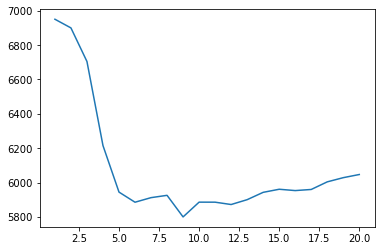

In [42]:
plt.figure()
#plt.plot(np.arange(20)+1,bic)
plt.plot(np.arange(20)+1,bic_new)

### and now : show-moi comme c'est bô

In [43]:
def compute_splines(res_data,nknots,errors):
    results=dict()
    for filt in filters:
        err_model = err_model_constant(errors[filt])
        C,xrefs = make_spline_fit(res_data[filt],nknots, err_model)
        yspl = sc.interpolate.splev(res_data[filt]['phase'],(xrefs,C,3))
        
        w = 1./ ( res_data[filt]['err_mag']**2 + err_model.error(res_data[filt]['phase'])**2)
        chi2 = np.sum((res_data[filt]['residual']-yspl)**2 * w)
        wrms = np.sqrt( chi2 / np.sum( w) )
        
        # here : the errors.
        B,xrefs = make_B_matrix(res_data[filt]['phase'],nknots)
        covar = get_spline_coef_covar(res_data[filt],nknots,err_model)
        y_err = np.sqrt( np.sum(B*covar.dot(B),axis=0) )
        
        results[filt] = {'tck':(xrefs,C,3),'yspl':yspl,'errors':errors[filt],'wrms':wrms,'chi2':chi2,'C_cov':covar,'yspl_err':y_err} 
        
    return results

In [44]:
splfit = compute_splines(flat_data,9,new_wrms)

In [45]:
def plot_data_model(data,splfit, filters=[ 'cspb', 'cspg',  'cspv', 'cspr', 'cspi']):
    plt.figure(figsize=(6,12))
    
    for i,filt in enumerate(filters):
        
        plt.subplot(len(filters), 1, i+1)
        plt.errorbar(data[filt]['phase'],data[filt]['residual'],yerr=data[filt]['err_mag'],fmt='.',color=filt_cols[filt])
        plt.plot(data[filt]['phase'],splfit[filt]['yspl'],'k',zorder=5)
        plt.fill_between(data[filt]['phase'],splfit[filt]['yspl']+splfit[filt]['errors'],splfit[filt]['yspl']-splfit[filt]['errors'],alpha=0.5,zorder=3,color='y')
        plt.fill_between(data[filt]['phase'],splfit[filt]['yspl']+splfit[filt]['yspl_err'],splfit[filt]['yspl']-splfit[filt]['yspl_err'],alpha=0.6,zorder=3,color='k')
        plt.fill_between(data[filt]['phase'],splfit[filt]['yspl']+splfit[filt]['yspl_err']*2,splfit[filt]['yspl']-splfit[filt]['yspl_err']*2,alpha=0.4,zorder=3,color='k')
        plt.fill_between(data[filt]['phase'],splfit[filt]['yspl']+splfit[filt]['yspl_err']*3,splfit[filt]['yspl']-splfit[filt]['yspl_err']*3,alpha=0.2,zorder=3,color='k')
        plt.plot((tfirst_glob,tlast_glob),(0,0),zorder=10,linewidth=0.5)

        plt.xlabel('Phase')
        plt.ylabel(filt + ' (mag)')
        plt.ylim(-0.15,0.15)

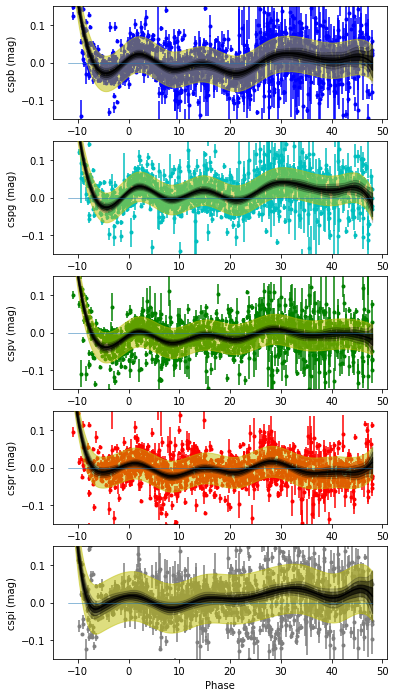

In [46]:
plot_data_model(flat_data,splfit)

#### is the mean non-0 ?

In [47]:
# This amonuts to computing errors on yspl, so we need errors on coefs.
# some leftover of the development phase ...

In [48]:
err_model = err_model_constant(new_wrms['cspb'])
covar = get_spline_coef_covar(flat_data['cspb'],9,err_model)


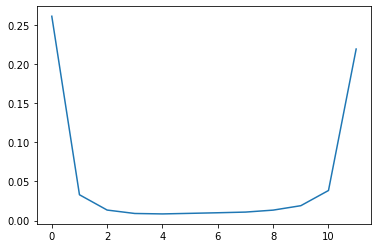

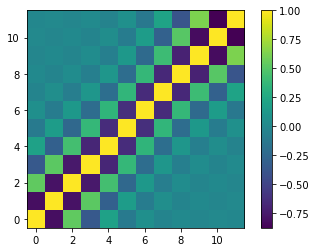

In [49]:
plt.figure()
plt.plot(np.sqrt(np.diag(covar)))
plt.figure()
plt.imshow(covar/np.sqrt(np.outer(np.diag(covar),np.diag(covar))))
plt.colorbar()

#### Some unit tests

In [50]:
B,xrefs = make_B_matrix(flat_data['cspb']['phase'],9)

In [51]:
# y = sum (c_i * B_i) ...
# let check this first
B.T.dot(splfit['cspb']['tck'][1]) - splfit['cspb']['yspl']

# All Clear.

array([ 0.00000000e+00,  0.00000000e+00, -5.55111512e-17, ...,
        4.87890978e-19, -3.08997619e-18,  1.57209315e-18])

In [52]:
#var (y) = sum (B_i cov(ij) B_j )
#y_var = np.diag(B.T.dot(covar).dot(B))
y_var = np.sum(B*covar.dot(B),axis=0)

In [53]:
# let's check this for y[0] : 
# y[0] = sum c_i B_i[0]
# var(y[0]) = covar c_i b_i[0]
B[:,1].dot(covar).dot(B[:,1]) - np.diag(B.T.dot(covar).dot(B))[1]

# All clear .. let's put this into a formula

0.0

# what now ?

In [54]:
# fit in 2D
# look for q1 dependency ...



#### do we have enough wavelength information ?

(array([ 7.,  5., 11.,  8.,  8.,  8.,  6.,  4.,  3.,  1.,  4.,  1.,  2.,
         3.,  2.,  0.,  0.,  1.,  1.,  2.]),
 array([0.00551138, 0.00936326, 0.01321514, 0.01706702, 0.0209189 ,
        0.02477078, 0.02862266, 0.03247454, 0.03632642, 0.04017831,
        0.04403019, 0.04788207, 0.05173395, 0.05558583, 0.05943771,
        0.06328959, 0.06714147, 0.07099335, 0.07484524, 0.07869712,
        0.082549  ]),
 <a list of 20 Patch objects>)

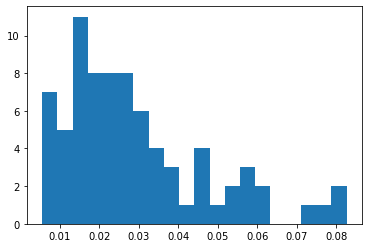

In [55]:
plt.figure()
plt.hist([data[sn]['zcmb'] for sn in data],bins=20)

In [56]:
zmax = np.max([data[sn]['zcmb'] for sn in data])

In [57]:
for filt in filt_wlength:
    print(filt, filt_wlength[filt], filt_wlength[filt]/(1+zmax))

cspb 4405.52523158631 4069.585065135785
cspg 4794.041505636825 4428.475309391375
cspv 5389.265240884614 4978.310685661943
cspr 6239.341129133972 5763.564646812442
cspi 7630.7634178811795 7048.885026998705


## Error model - no mean at all (ouch !!)

In [58]:
# first : compute the likelihood of the spline !

In [59]:
# Once for all ...
make_B_matrix(phases,nknots,tfirst=tfirst_glob,tlast=tlast_glob):
    
    def make_spline_fit(res_data,nknots,err_model=err_model_constant()):
    B,xrefs = make_B_matrix(res_data['phase'],nknots)
    w = 1./ ( res_data['err_mag']**2 + err_model.error(res_data['phase'])**2)
    By = B.dot(res_data['residual'] * w)
    BB = (B * w ) .dot(B.T) # here the weights will take place
    cho = sc.linalg.cho_factor(BB)
    C = sc.linalg.cho_solve (cho,By)
    return C,xrefs

    for filt in filters:
        err_model = err_model_constant(errors[filt])
        C,xrefs = make_spline_fit(res_data[filt],nknots, err_model)
        yspl = sc.interpolate.splev(res_data[filt]['phase'],(xrefs,C,3))
        
        w = 1./ ( res_data[filt]['err_mag']**2 + err_model.error(res_data[filt]['phase'])**2)
        chi2 = np.sum((res_data[filt]['residual']-yspl)**2 * w)
      
    
def compute_likelihood():
    # 

SyntaxError: invalid syntax (<ipython-input-59-979d9d8c88fd>, line 2)

In [60]:
class error_model_1D:
    """ a 1D error model models the error snake as a spline on the data"""
    
    def __init__(self,nknots,nknots_err,degree=3,tfirst=tfirst_glob,tlast=tlast_glob ):
        # nknots : number of knots for average fit
        # nknots_err : number of knots for error band fit.
        self.nknots = nknots
        self.nknots_err = nknots_err 
        self.degree = degree
        self.tfirst = tfirst
        self.tlast = tlast
    
    def prepare_fit(self,res_data):
        """imports the data and runs precomputations
        data is a dictionary containing the following keywords:
            'phase' : phase
            'residuals' : fit residuals 
            'err_mag' : the photometric errors on data points
            """
        self.res_data = res_data
        self.B, self.xrefs = make_B_matrix(res_data['phase'],self.nknots,self.tfirst,self.tlast,self.degree)        
        self.B_err, self.xrefs_err = make_B_matrix(res_data['phase'],self.nknots_err,self.tfirst,self.tlast,self.degree)        


        
    def guess_error(self):
        """initial guess for the error model : returns the wrms"""
        wrms = np.sqrt(np.sum((self.res_data['residual'])**2 / np.array(self.res_data['err_mag'])**2) \
    / np.sum(1./np.array(self.res_data['err_mag'])**2))
        return wrms
        
        
    def get_likelihood(self,C):
        """C is the array of spline coefficients : it shouls be of rank nknots + degree
        this supposes self.xrefs has been computed
        
        Caveat : here, mean is assumed to be 0"""
        yerrs = sc.interpolate.splev(self.res_data['phase'],(self.xrefs_err,C,self.degree))
        # note that the error model doesn't suppose any phase correlation.
        # and this furst version implies that residuals are correct.
        
        w = 1./ ( self.res_data['err_mag']**2 + yerrs**2)
        
        # chi2
        return np.sum((self.res_data['residual'])**2 * w) - np.sum ( np.log(w) )
    
    
    
    def get_restricted_likelihood(self,C):
        """C is the array of spline coefficients : it shouls be of rank nknots + degree
        this supposes self.xrefs has been computed
        This variant fits also for the average of the residuals"""
        yerrs = sc.interpolate.splev(self.res_data['phase'],(self.xrefs_err,C,self.degree))
        # note that the error model doesn't suppose any phase correlation.
       
        # as this is the internal fit routine, nothing is stored...
        
        w = 1./ ( self.res_data['err_mag']**2 + yerrs**2)
        
        By = self.B.dot(self.res_data['residual'] * w)
        BB = (self.B * w ) .dot(self.B.T) # here the weights will take place
        cho = sc.linalg.cho_factor(BB)
        C = sc.linalg.cho_solve (cho,By)
        yspl = sc.interpolate.splev(self.res_data['phase'],(self.xrefs,C,3))   
        
        chi2 = np.sum((self.res_data['residual']-yspl)**2 * w)
        
        REML = chi2 - np.sum ( np.log(w) ) + np.log( np.linalg.det(BB))
        
        # chi2
        return REML
    
    def fit_error_model(self):
        self.err_C = sc.optimize.fmin(self.get_likelihood,self.guess_error()*np.ones(self.nknots_err+self.degree),maxiter=1000)
        self.err_C = sc.optimize.fmin(self.get_likelihood,self.err_C,maxiter=1000)
        self.err_C = sc.optimize.fmin(self.get_likelihood,self.err_C,maxiter=1000)
        self.likelihood_converged = self.get_likelihood(self.err_C)
        
    def fit_full_model(self):
        self.err_C = sc.optimize.fmin(self.get_restricted_likelihood,self.guess_error()*np.ones(self.nknots_err+self.degree),maxiter=1000)
        self.err_C = sc.optimize.fmin(self.get_restricted_likelihood,self.err_C,maxiter=1000)
        self.err_C = sc.optimize.fmin(self.get_restricted_likelihood,self.err_C,maxiter=1000)
        self.likelihood_converged = self.get_restricted_likelihood(self.err_C)

    def compute_model_errors(self):
        self.y_model_err = sc.interpolate.splev(self.res_data['phase'],(self.xrefs_err,self.err_C,self.degree))
        w = 1./ ( self.res_data['err_mag']**2 + self.y_model_err**2)
        self.yspl=np.zeros_like(self.res_data['phase'])
        self.y_err = np.zeros_like(self.res_data['phase'])
        self.chi2 = np.sum((self.res_data['residual']-self.yspl)**2 * w)
    
    def compute_full_model(self):
        """finalize model computation once it is converged"""
        
        yerrs = sc.interpolate.splev(self.res_data['phase'],(self.xrefs_err,self.err_C,self.degree))
        self.y_model_err=yerrs
        # note that the error model doesn't suppose any phase correlation.
       
        w = 1./ ( self.res_data['err_mag']**2 + yerrs**2)
        
        By = self.B.dot(self.res_data['residual'] * w)
        BB = (self.B * w ) .dot(self.B.T) # here the weights will take place
        cho = sc.linalg.cho_factor(BB)
        C = sc.linalg.cho_solve (cho,By)
        self.yspl = sc.interpolate.splev(self.res_data['phase'],(self.xrefs,C,3))   
        
        self.chi2 = np.sum((self.res_data['residual']-self.yspl)**2 * w)
        
        #REML = chi2 - np.sum ( np.log(w) ) #+ np.log( np.linalg.det(BB))
        
        # here : the errors.
    
    
        covar = np.linalg.inv(BB)
        self.y_err = np.sqrt( np.sum(self.B*covar.dot(self.B),axis=0) )
        
        # chi2
        #return REML
        

In [61]:
err_mod = error_model_1D(1,9)
err_mod.prepare_fit(flat_data['cspb'])
err_mod.get_likelihood(np.ones(12)*0.053)

-5609.740328645179

In [62]:
err_mod.fit_error_model()
err_mod.compute_model_errors()

Optimization terminated successfully.
         Current function value: -5961.053509
         Iterations: 642
         Function evaluations: 900


In [63]:
def make_error_model_1D(res_data,nknots,nknots_err):
    error_model = dict()
    for filt in filters:
        err_mod = error_model_1D(nknots,nknots_err)
        err_mod.prepare_fit(flat_data[filt])
        err_mod.fit_error_model()
        err_mod.compute_model_errors()
        error_model[filt] = err_mod
    return error_model

def make_full_model_1D(res_data,nknots,nknots_err):
    error_model = dict()
    for filt in filters:
        err_mod = error_model_1D(nknots,nknots_err)
        err_mod.prepare_fit(flat_data[filt])
        err_mod.fit_full_model()
        err_mod.compute_full_model()
        error_model[filt] = err_mod
    return error_model

In [64]:
e_model = make_error_model_1D(flat_data,1,9)

Optimization terminated successfully.
         Current function value: -5961.053509
         Iterations: 642
         Function evaluations: 900
Optimization terminated successfully.
         Current function value: -6227.159738
         Iterations: 493
         Function evaluations: 730
Optimization terminated successfully.
         Current function value: -6568.105018
         Iterations: 633
         Function evaluations: 903
Optimization terminated successfully.
         Current function value: -6593.333829
         Iterations: 972
         Function evaluations: 1337
Optimization terminated successfully.
         Current function value: -5891.815373
         Iterations: 842
         Function evaluations: 1198


In [65]:
def plot_error_model(data,error_model, filters=[ 'cspb', 'cspg',  'cspv', 'cspr', 'cspi'],ylim=0):
    plt.figure(figsize=(6,12))
    
    for i,filt in enumerate(filters):
        
        plt.subplot(len(filters), 1, i+1)
        plt.errorbar(data[filt]['phase'],data[filt]['residual'],yerr=data[filt]['err_mag'],fmt='.',color=filt_cols[filt],zorder=1)
        
        plt.plot(data[filt]['phase'],error_model[filt].yspl,'k',zorder=5)
        plt.fill_between(data[filt]['phase'],error_model[filt].yspl+error_model[filt].y_model_err,error_model[filt].yspl-error_model[filt].y_model_err,alpha=0.7,zorder=2,color='y')


        plt.fill_between(data[filt]['phase'],error_model[filt].yspl+error_model[filt].y_err,error_model[filt].yspl-error_model[filt].y_err,alpha=0.6,zorder=3,color='k')
        plt.fill_between(data[filt]['phase'],error_model[filt].yspl+error_model[filt].y_err*2,error_model[filt].yspl-error_model[filt].y_err*2,alpha=0.4,zorder=3,color='k')
        plt.fill_between(data[filt]['phase'],error_model[filt].yspl+error_model[filt].y_err*3,error_model[filt].yspl-error_model[filt].y_err*3,alpha=0.2,zorder=3,color='k')

        plt.plot((tfirst_glob,tlast_glob),(0,0),zorder=10,linewidth=0.5)

        plt.xlabel('Phase')
        plt.ylabel(filt + ' (mag)')
        if ylim:
            plt.ylim(-ylim,ylim)

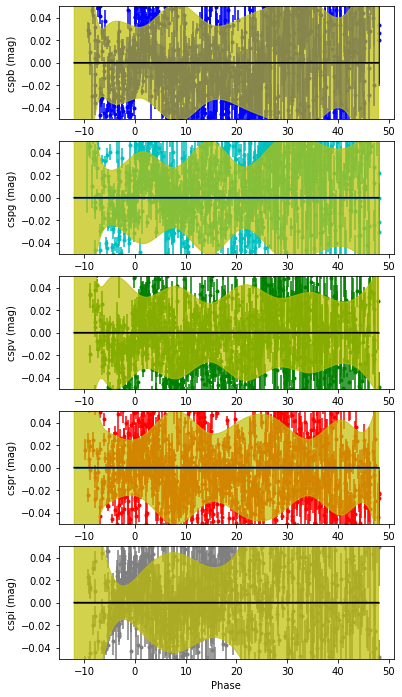

In [66]:
plot_error_model(flat_data,e_model,ylim=0.05)

#### And the BIC ! Takes time, better skip for a demo

In [442]:
def compute_bic_1D(error_model):
    bic = 0
    for filt in error_model:
        em = error_model[filt]
        bic += em.likelihood_converged + (em.nknots + em.degree + em.nknots_err + em.degree)*np.log(len(em.res_data['phase']))
    return bic

In [364]:
compute_bic_1D(e_model)

-30815.54235168383

In [365]:
bic=list()
for nknots in range(20):
    e_model = make_error_model_1D(flat_data,nknots+1)
    bic += [compute_bic_1D(e_model)]

Optimization terminated successfully.
         Current function value: -5778.657570
         Iterations: 161
         Function evaluations: 278
Optimization terminated successfully.
         Current function value: -5778.657570
         Iterations: 57
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -5778.657570
         Iterations: 57
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -6041.759152
         Iterations: 161
         Function evaluations: 269
Optimization terminated successfully.
         Current function value: -6041.759152
         Iterations: 58
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -6041.759152
         Iterations: 58
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -6449.154230
         Iterations: 180
         Function evaluations: 

Optimization terminated successfully.
         Current function value: -5913.040259
         Iterations: 114
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: -5913.040259
         Iterations: 103
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: -6164.990998
         Iterations: 113
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: -6164.991003
         Iterations: 104
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -6523.813240
         Iterations: 124
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: -6523.813240
         Iterations: 118
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -6539.633282
         Iterations: 184
         Function evaluatio

Optimization terminated successfully.
         Current function value: -6587.720284
         Iterations: 626
         Function evaluations: 899


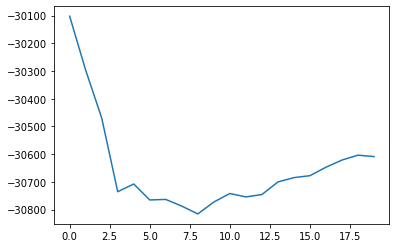

In [367]:
plt.figure()
plt.plot(bic)

In [63]:
e_model = make_error_model_1D(flat_data,1,9)

Optimization terminated successfully.
         Current function value: -5961.053509
         Iterations: 642
         Function evaluations: 900
Optimization terminated successfully.
         Current function value: -6227.159738
         Iterations: 493
         Function evaluations: 730
Optimization terminated successfully.
         Current function value: -6568.105018
         Iterations: 633
         Function evaluations: 903
Optimization terminated successfully.
         Current function value: -6593.333829
         Iterations: 972
         Function evaluations: 1337
Optimization terminated successfully.
         Current function value: -5891.815373
         Iterations: 842
         Function evaluations: 1198


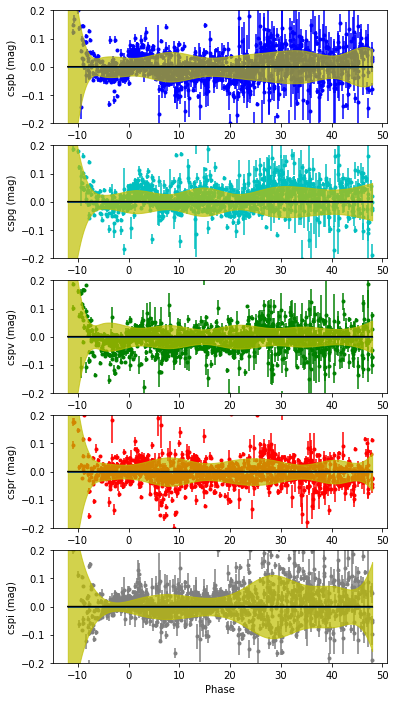

In [64]:
plot_error_model(flat_data,e_model,ylim=0.2)

In [66]:
e_model = make_full_model_1D(flat_data,9,9)

Optimization terminated successfully.
         Current function value: -6087.485891
         Iterations: 487
         Function evaluations: 732
Optimization terminated successfully.
         Current function value: -6459.778596
         Iterations: 201
         Function evaluations: 321
Optimization terminated successfully.
         Current function value: -6659.314603
         Iterations: 548
         Function evaluations: 783
Optimization terminated successfully.
         Current function value: -6589.992483
         Iterations: 720
         Function evaluations: 993
Optimization terminated successfully.
         Current function value: -5968.353960
         Iterations: 860
         Function evaluations: 1202


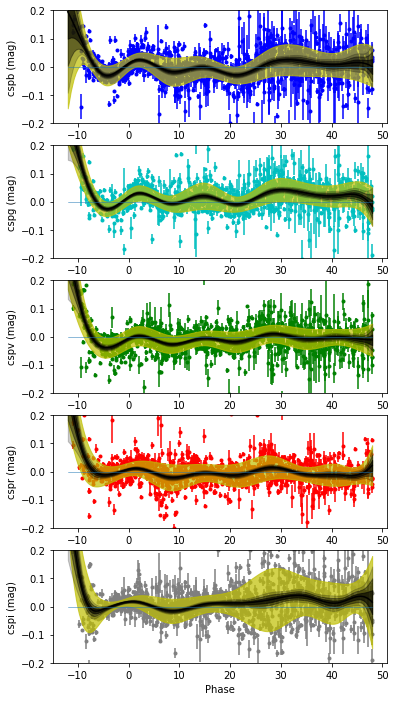

In [67]:
plot_error_model(flat_data,e_model,ylim=0.2)

In [69]:
e_model = make_full_model_1D(flat_data,8,8)

Optimization terminated successfully.
         Current function value: -6052.569297
         Iterations: 353
         Function evaluations: 524
Optimization terminated successfully.
         Current function value: -6364.635706
         Iterations: 988
         Function evaluations: 1396
Optimization terminated successfully.
         Current function value: -6374.857633
         Iterations: 187
         Function evaluations: 308
Optimization terminated successfully.
         Current function value: -6608.314100
         Iterations: 232
         Function evaluations: 357
Optimization terminated successfully.
         Current function value: -6565.674158
         Iterations: 313
         Function evaluations: 484
Optimization terminated successfully.
         Current function value: -5965.258082
         Iterations: 235
         Function evaluations: 376


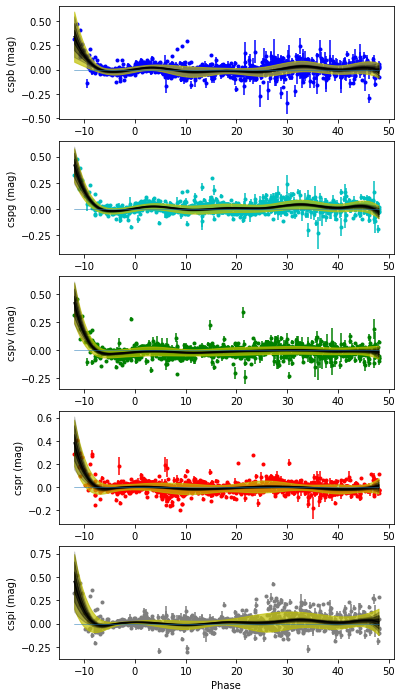

In [70]:
plot_error_model(flat_data,e_model,ylim=0)

#### and this is the bibique !

# C'est long, foaut skipper

In [458]:
bic=list()
for nknots in range(20):
    e_model = make_full_model_1D(flat_data,nknots+1,8)
    bic += [compute_bic_1D(e_model)]

Optimization terminated successfully.
         Current function value: -5951.328890
         Iterations: 699
         Function evaluations: 985
Optimization terminated successfully.
         Current function value: -6620.969147
         Iterations: 518
         Function evaluations: 750
Optimization terminated successfully.
         Current function value: -6575.351735
         Iterations: 574
         Function evaluations: 838
Optimization terminated successfully.
         Current function value: -5918.027507
         Iterations: 924
         Function evaluations: 1295
Optimization terminated successfully.
         Current function value: -5980.596638
         Iterations: 856
         Function evaluations: 1197
Optimization terminated successfully.
         Current function value: -6308.756328
         Iterations: 404
         Function evaluations: 614
Optimization terminated successfully.
         Current function value: -6612.048972
         Iterations: 251
         Function evaluat

Optimization terminated successfully.
         Current function value: -6619.823634
         Iterations: 924
         Function evaluations: 1289
Optimization terminated successfully.
         Current function value: -6619.823634
         Iterations: 198
         Function evaluations: 316
Optimization terminated successfully.
         Current function value: -6578.785202
         Iterations: 691
         Function evaluations: 988
Optimization terminated successfully.
         Current function value: -5966.244215
         Iterations: 974
         Function evaluations: 1370
Optimization terminated successfully.
         Current function value: -6052.569297
         Iterations: 353
         Function evaluations: 524
Optimization terminated successfully.
         Current function value: -6364.635706
         Iterations: 988
         Function evaluations: 1396
Optimization terminated successfully.
         Current function value: -6374.857633
         Iterations: 187
         Function evalua

Optimization terminated successfully.
         Current function value: -6649.970503
         Iterations: 227
         Function evaluations: 350
Optimization terminated successfully.
         Current function value: -6574.508384
         Iterations: 987
         Function evaluations: 1365
Optimization terminated successfully.
         Current function value: -6065.830475
         Iterations: 963
         Function evaluations: 1331
Optimization terminated successfully.
         Current function value: -6065.830475
         Iterations: 185
         Function evaluations: 302
Optimization terminated successfully.
         Current function value: -6404.804351
         Iterations: 940
         Function evaluations: 1316
Optimization terminated successfully.
         Current function value: -6415.344698
         Iterations: 921
         Function evaluations: 1293
Optimization terminated successfully.
         Current function value: -6415.344698
         Iterations: 181
         Function evalu

Optimization terminated successfully.
         Current function value: -6407.460111
         Iterations: 363
         Function evaluations: 540
Optimization terminated successfully.
         Current function value: -6622.919970
         Iterations: 684
         Function evaluations: 957
Optimization terminated successfully.
         Current function value: -6622.919972
         Iterations: 210
         Function evaluations: 329
Optimization terminated successfully.
         Current function value: -6543.988679
         Iterations: 288
         Function evaluations: 452
Optimization terminated successfully.
         Current function value: -6036.350281
         Iterations: 991
         Function evaluations: 1378
Optimization terminated successfully.
         Current function value: -6036.350281
         Iterations: 174
         Function evaluations: 287
Optimization terminated successfully.
         Current function value: -6402.741852
         Iterations: 185
         Function evaluati

[-30841.301188118694, -30847.522718232343, -30809.6741742453, -30857.323504733336, -30930.620923851846, -30899.895008183215, -30792.93966814639, -30785.81056043032, -30936.017252021837, -30769.092036870585, -30749.379351398202, -30776.46510540539, -30722.104619650552, -30614.541650135212, -30557.994066872317, -30545.18114518466, -30492.722185135266, -30401.77362030068, -30343.9864451674, -30289.58959450917]


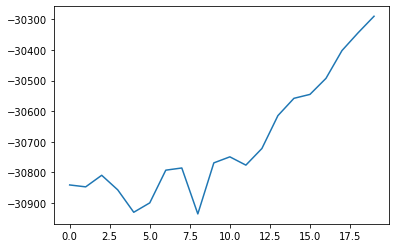

In [460]:
plt.figure()
plt.plot(bic)
print (bic)

In [461]:
bic=list()
for nknots in range(20):
    e_model = make_full_model_1D(flat_data,9,nknots+1)
    bic += [compute_bic_1D(e_model)]

Optimization terminated successfully.
         Current function value: -5953.585412
         Iterations: 154
         Function evaluations: 265
Optimization terminated successfully.
         Current function value: -5953.585412
         Iterations: 44
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -5953.585412
         Iterations: 44
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -6375.991632
         Iterations: 176
         Function evaluations: 309
Optimization terminated successfully.
         Current function value: -6375.991632
         Iterations: 58
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -6375.991632
         Iterations: 58
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -6628.398065
         Iterations: 153
         Function evaluations: 259


Optimization terminated successfully.
         Current function value: -6048.647613
         Iterations: 102
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: -6048.647614
         Iterations: 122
         Function evaluations: 204
Optimization terminated successfully.
         Current function value: -6437.359766
         Iterations: 963
         Function evaluations: 1423
Optimization terminated successfully.
         Current function value: -6437.359766
         Iterations: 117
         Function evaluations: 192
Optimization terminated successfully.
         Current function value: -6437.359766
         Iterations: 117
         Function evaluations: 192
Optimization terminated successfully.
         Current function value: -6655.519223
         Iterations: 194
         Function evaluations: 303
Optimization terminated successfully.
         Current function value: -6655.520638
         Iterations: 179
         Function evaluati

Optimization terminated successfully.
         Current function value: -6665.182479
         Iterations: 559
         Function evaluations: 801
Optimization terminated successfully.
         Current function value: -6460.128155
         Iterations: 344
         Function evaluations: 524
Optimization terminated successfully.
         Current function value: -6667.763508
         Iterations: 597
         Function evaluations: 839
Optimization terminated successfully.
         Current function value: -6463.048018
         Iterations: 738
         Function evaluations: 986


[-30547.94777821214, -30696.60417790214, -30789.95270151827, -30923.133880079222, -30885.46909610639, -30927.029014905886, -30904.882710846345, -30936.017252021837, -30913.07530467067, -30887.520712673737, -30882.155491023557, -30865.16832229859, -30850.079089249146, -30803.23830233055, -30776.90731035263, -30759.5912002405, -30732.026479261553, -30711.01219042233, -30705.262799916633, -30680.1374851288]


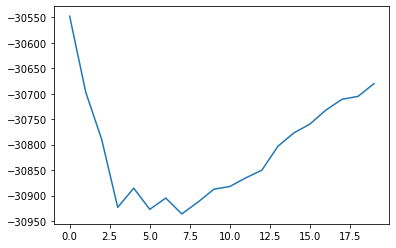

In [462]:
plt.figure()
plt.plot(bic)
print (bic)

In [463]:
bic=list()
for nknots in range(12):
    e_model = make_full_model_1D(flat_data,5,nknots+1)
    bic += [compute_bic_1D(e_model)]

Optimization terminated successfully.
         Current function value: -5928.727143
         Iterations: 170
         Function evaluations: 287
Optimization terminated successfully.
         Current function value: -5928.727143
         Iterations: 46
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -5928.727143
         Iterations: 48
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -6299.190478
         Iterations: 269
         Function evaluations: 457
Optimization terminated successfully.
         Current function value: -6299.190478
         Iterations: 48
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -6299.190478
         Iterations: 47
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -6592.327790
         Iterations: 166
         Function evaluations: 269


Optimization terminated successfully.
         Current function value: -6020.851531
         Iterations: 989
         Function evaluations: 1437
Optimization terminated successfully.
         Current function value: -6020.851531
         Iterations: 122
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: -6020.851531
         Iterations: 122
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: -6373.389235
         Iterations: 903
         Function evaluations: 1324
Optimization terminated successfully.
         Current function value: -6373.389237
         Iterations: 117
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -6373.389237
         Iterations: 116
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -6628.359091
         Iterations: 556
         Function evaluat

Optimization terminated successfully.
         Current function value: -6046.628684
         Iterations: 702
         Function evaluations: 977
Optimization terminated successfully.
         Current function value: -6636.292062
         Iterations: 354
         Function evaluations: 536
Optimization terminated successfully.
         Current function value: -6585.135825
         Iterations: 493
         Function evaluations: 720
Optimization terminated successfully.
         Current function value: -6390.378880
         Iterations: 859
         Function evaluations: 1168
Optimization terminated successfully.
         Current function value: -6589.064296
         Iterations: 594
         Function evaluations: 850


[-30477.85788447718, -30654.62632180663, -30769.980535131333, -30924.565411829095, -30878.83543299971, -30928.598644845377, -30898.757172912356, -30930.620923851846, -30906.35598741309, -30867.999448794617, -30860.637865745608, -30855.02954034942]


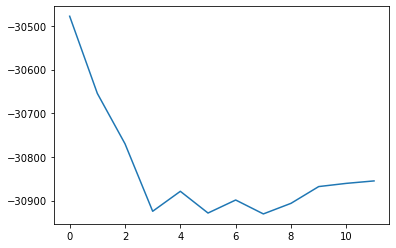

In [464]:
plt.figure()
plt.plot(bic)
print (bic)

In [465]:
bic=list()
for nknots in range(14):
    e_model = make_full_model_1D(flat_data,nknots+1,6)
    bic += [compute_bic_1D(e_model)]

Optimization terminated successfully.
         Current function value: -5920.113139
         Iterations: 866
         Function evaluations: 1223
Optimization terminated successfully.
         Current function value: -5920.113139
         Iterations: 168
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: -6278.293999
         Iterations: 705
         Function evaluations: 1013
Optimization terminated successfully.
         Current function value: -6278.293999
         Iterations: 154
         Function evaluations: 259
Optimization terminated successfully.
         Current function value: -6613.873446
         Iterations: 889
         Function evaluations: 1277
Optimization terminated successfully.
         Current function value: -6613.873446
         Iterations: 164
         Function evaluations: 265
Optimization terminated successfully.
         Current function value: -6540.474307
         Iterations: 701
         Function evalua

Optimization terminated successfully.
         Current function value: -5946.228016
         Iterations: 691
         Function evaluations: 1003
Optimization terminated successfully.
         Current function value: -5946.228016
         Iterations: 153
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: -6014.379531
         Iterations: 494
         Function evaluations: 723
Optimization terminated successfully.
         Current function value: -6014.379531
         Iterations: 139
         Function evaluations: 227
Optimization terminated successfully.
         Current function value: -6361.837056
         Iterations: 587
         Function evaluations: 858
Optimization terminated successfully.
         Current function value: -6361.837056
         Iterations: 143
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: -6634.272310
         Iterations: 137
         Function evaluati

Optimization terminated successfully.
         Current function value: -6630.903180
         Iterations: 629
         Function evaluations: 910
Optimization terminated successfully.
         Current function value: -6630.903190
         Iterations: 118
         Function evaluations: 205
Optimization terminated successfully.
         Current function value: -6550.852001
         Iterations: 875
         Function evaluations: 1246
Optimization terminated successfully.
         Current function value: -6550.852270
         Iterations: 251
         Function evaluations: 380
Optimization terminated successfully.
         Current function value: -6550.852270
         Iterations: 146
         Function evaluations: 242
Optimization terminated successfully.
         Current function value: -5951.606411
         Iterations: 985
         Function evaluations: 1434
Optimization terminated successfully.
         Current function value: -5951.606411
         Iterations: 153
         Function evaluat

[-30823.612385731067, -30817.344876897943, -30777.421992044598, -30841.87064798209, -30928.598644845377, -30901.26202953213, -30793.915758771593, -30784.936716236185, -30927.029014905886, -30762.793278961497, -30743.440482518858, -30766.67187060539, -30709.965368583005, -30603.1768725967]


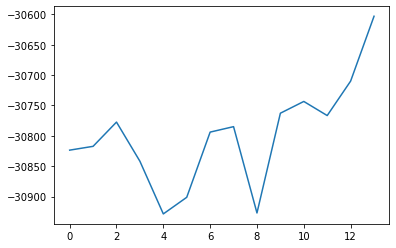

In [466]:
plt.figure()
plt.plot(bic)
print (bic)

In [467]:
bic=list()
for nknots in range(14):
    e_model = make_full_model_1D(flat_data,nknots+1,4)
    bic += [compute_bic_1D(e_model)]

Optimization terminated successfully.
         Current function value: -5906.807183
         Iterations: 593
         Function evaluations: 888
Optimization terminated successfully.
         Current function value: -5906.807183
         Iterations: 99
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -5906.807183
         Iterations: 99
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -6240.252445
         Iterations: 959
         Function evaluations: 1458
Optimization terminated successfully.
         Current function value: -6240.252445
         Iterations: 105
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -6240.252445
         Iterations: 105
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -6575.413947
         Iterations: 717
         Function evaluation

Optimization terminated successfully.
         Current function value: -6009.299522
         Iterations: 366
         Function evaluations: 558
Optimization terminated successfully.
         Current function value: -6009.328922
         Iterations: 170
         Function evaluations: 284
Optimization terminated successfully.
         Current function value: -6009.328922
         Iterations: 97
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -6366.938593
         Iterations: 661
         Function evaluations: 985
Optimization terminated successfully.
         Current function value: -6366.938593
         Iterations: 96
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -6366.938593
         Iterations: 96
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -6619.570523
         Iterations: 641
         Function evaluations:

Optimization terminated successfully.
         Current function value: -6031.838714
         Iterations: 623
         Function evaluations: 928
Optimization terminated successfully.
         Current function value: -6031.838716
         Iterations: 106
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: -6031.838716
         Iterations: 99
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: -6429.456344
         Iterations: 806
         Function evaluations: 1210
Optimization terminated successfully.
         Current function value: -6429.456344
         Iterations: 98
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -6429.456344
         Iterations: 90
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -6648.439396
         Iterations: 550
         Function evaluations

Optimization terminated successfully.
         Current function value: -5911.504015
         Iterations: 114
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: -6012.373698
         Iterations: 679
         Function evaluations: 1020
Optimization terminated successfully.
         Current function value: -6012.373698
         Iterations: 104
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -6012.373698
         Iterations: 104
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -6422.145167
         Iterations: 727
         Function evaluations: 1086
Optimization terminated successfully.
         Current function value: -6422.145167
         Iterations: 74
         Function evaluations: 134
Optimization terminated successfully.
         Current function value: -6422.145167
         Iterations: 79
         Function evaluatio

[-30766.243663091085, -30755.345844448835, -30709.669000105157, -30816.214066536253, -30924.565411829095, -30901.44697655017, -30797.07070500608, -30782.281853809363, -30923.133880079222, -30761.574281105448, -30739.45086938805, -30757.818734974917, -30699.210327384404, -30595.508977368845]


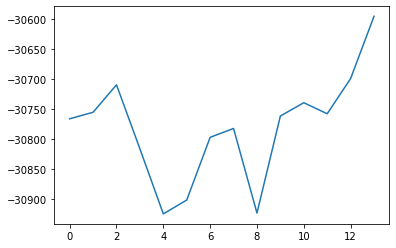

In [468]:
plt.figure()
plt.plot(bic)
print (bic)

In [470]:
bic=list()
for nknots in range(14):
    e_model = make_full_model_1D(flat_data,nknots+1,5)
    bic += [compute_bic_1D(e_model)]

Optimization terminated successfully.
         Current function value: -5904.872892
         Iterations: 862
         Function evaluations: 1255
Optimization terminated successfully.
         Current function value: -5904.872892
         Iterations: 118
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: -5904.872892
         Iterations: 127
         Function evaluations: 209
Optimization terminated successfully.
         Current function value: -6257.155971
         Iterations: 568
         Function evaluations: 846
Optimization terminated successfully.
         Current function value: -6257.799536
         Iterations: 297
         Function evaluations: 458
Optimization terminated successfully.
         Current function value: -6604.173105
         Iterations: 941
         Function evaluations: 1387
Optimization terminated successfully.
         Current function value: -6604.173106
         Iterations: 134
         Function evaluat

Optimization terminated successfully.
         Current function value: -6628.359091
         Iterations: 556
         Function evaluations: 827
Optimization terminated successfully.
         Current function value: -6628.360159
         Iterations: 210
         Function evaluations: 329
Optimization terminated successfully.
         Current function value: -6628.360160
         Iterations: 114
         Function evaluations: 193
Optimization terminated successfully.
         Current function value: -6536.339475
         Iterations: 927
         Function evaluations: 1381
Optimization terminated successfully.
         Current function value: -6536.339476
         Iterations: 127
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: -6536.339476
         Iterations: 119
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: -5887.795179
         Iterations: 350
         Function evaluati

Optimization terminated successfully.
         Current function value: -5903.874960
         Iterations: 567
         Function evaluations: 839
Optimization terminated successfully.
         Current function value: -5903.874960
         Iterations: 130
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: -6016.309904
         Iterations: 114
         Function evaluations: 192
Optimization terminated successfully.
         Current function value: -6016.309904
         Iterations: 127
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: -6383.647380
         Iterations: 305
         Function evaluations: 456
Optimization terminated successfully.
         Current function value: -6383.647381
         Iterations: 127
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: -6631.233855
         Iterations: 899
         Function evaluatio

Optimization terminated successfully.
         Current function value: -6405.790875
         Iterations: 113
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: -6405.790875
         Iterations: 121
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: -6634.134627
         Iterations: 237
         Function evaluations: 371
Optimization terminated successfully.
         Current function value: -6634.134628
         Iterations: 115
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: -6516.772849
         Iterations: 791
         Function evaluations: 1172
Optimization terminated successfully.
         Current function value: -6516.772849
         Iterations: 124
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: -6516.772849
         Iterations: 124
         Function evaluati

[-30741.7863491802, -30735.881398244117, -30695.70977546487, -30789.14802343375, -30878.83543299971, -30853.525703884516, -30750.718775875954, -30732.28934523032, -30885.46909610639, -30722.018689716526, -30700.558602724235, -30726.62466206093, -30668.781435332243, -30563.60164380466]


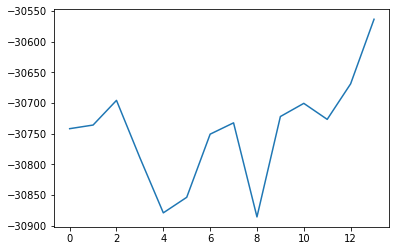

In [471]:
plt.figure()
plt.plot(bic)
print (bic)

In [472]:
bic=list()
for nknots in range(14):
    e_model = make_full_model_1D(flat_data,nknots+1,7)
    bic += [compute_bic_1D(e_model)]

Optimization terminated successfully.
         Current function value: -5928.182249
         Iterations: 722
         Function evaluations: 1033
Optimization terminated successfully.
         Current function value: -5928.182249
         Iterations: 135
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: -6284.401786
         Iterations: 862
         Function evaluations: 1228
Optimization terminated successfully.
         Current function value: -6284.401786
         Iterations: 202
         Function evaluations: 313
Optimization terminated successfully.
         Current function value: -6620.852286
         Iterations: 899
         Function evaluations: 1279
Optimization terminated successfully.
         Current function value: -6620.852286
         Iterations: 163
         Function evaluations: 266
Optimization terminated successfully.
         Current function value: -6551.190012
         Iterations: 747
         Function evalua

Optimization terminated successfully.
         Current function value: -6360.912343
         Iterations: 772
         Function evaluations: 1093
Optimization terminated successfully.
         Current function value: -6369.832106
         Iterations: 714
         Function evaluations: 1012
Optimization terminated successfully.
         Current function value: -6369.832107
         Iterations: 167
         Function evaluations: 270
Optimization terminated successfully.
         Current function value: -6637.915441
         Iterations: 646
         Function evaluations: 916
Optimization terminated successfully.
         Current function value: -6637.915442
         Iterations: 182
         Function evaluations: 283
Optimization terminated successfully.
         Current function value: -6567.240778
         Iterations: 642
         Function evaluations: 926
Optimization terminated successfully.
         Current function value: -6567.240778
         Iterations: 161
         Function evaluat

Optimization terminated successfully.
         Current function value: -6423.450123
         Iterations: 140
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: -6638.992439
         Iterations: 947
         Function evaluations: 1314
Optimization terminated successfully.
         Current function value: -6638.992439
         Iterations: 187
         Function evaluations: 290
Optimization terminated successfully.
         Current function value: -6545.573278
         Iterations: 733
         Function evaluations: 1064
Optimization terminated successfully.
         Current function value: -6545.573279
         Iterations: 173
         Function evaluations: 277
Optimization terminated successfully.
         Current function value: -5920.258012
         Iterations: 954
         Function evaluations: 1333
Optimization terminated successfully.
         Current function value: -5920.258012
         Iterations: 199
         Function evalua

[-30803.12728640282, -30808.962015273468, -30767.17026751945, -30824.575640057006, -30898.757172912356, -30868.558021027413, -30769.12560929282, -30754.433796002275, -30904.882710846345, -30741.996441113723, -30718.874288709958, -30746.87960733245, -30691.022352902564, -30583.972117645255]


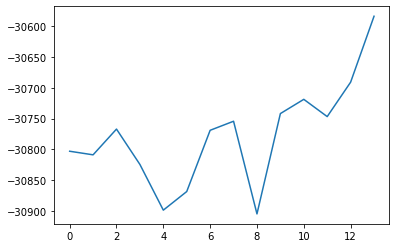

In [473]:
plt.figure()
plt.plot(bic)
print (bic)

In [474]:
bic=list()
for nknots in range(14):
    e_model = make_full_model_1D(flat_data,nknots+1,9)
    bic += [compute_bic_1D(e_model)]

Optimization terminated successfully.
         Current function value: -6575.236296
         Iterations: 411
         Function evaluations: 621
Optimization terminated successfully.
         Current function value: -5943.403357
         Iterations: 686
         Function evaluations: 971
Optimization terminated successfully.
         Current function value: -5976.584958
         Iterations: 443
         Function evaluations: 650
Optimization terminated successfully.
         Current function value: -6318.346549
         Iterations: 406
         Function evaluations: 603
Optimization terminated successfully.
         Current function value: -6299.445061
         Iterations: 417
         Function evaluations: 629
Optimization terminated successfully.
         Current function value: -6021.723529
         Iterations: 667
         Function evaluations: 941
Optimization terminated successfully.
         Current function value: -6351.529758
         Iterations: 352
         Function evaluatio

Optimization terminated successfully.
         Current function value: -6385.727480
         Iterations: 875
         Function evaluations: 1213
Optimization terminated successfully.
         Current function value: -6385.727481
         Iterations: 198
         Function evaluations: 326
Optimization terminated successfully.
         Current function value: -6610.910502
         Iterations: 627
         Function evaluations: 896
Optimization terminated successfully.
         Current function value: -6566.511355
         Iterations: 395
         Function evaluations: 594
Optimization terminated successfully.
         Current function value: -5969.389210
         Iterations: 837
         Function evaluations: 1162
Optimization terminated successfully.
         Current function value: -6087.485891
         Iterations: 487
         Function evaluations: 732
Optimization terminated successfully.
         Current function value: -6459.778596
         Iterations: 201
         Function evaluat

Optimization terminated successfully.
         Current function value: -6636.541262
         Iterations: 827
         Function evaluations: 1152
Optimization terminated successfully.
         Current function value: -6641.175117
         Iterations: 233
         Function evaluations: 360
Optimization terminated successfully.
         Current function value: -6555.882827
         Iterations: 691
         Function evaluations: 970


[-30786.260024293748, -30823.265676907413, -30780.97094823051, -30836.85626089867, -30906.35598741309, -30876.72410389368, -30774.552955565687, -30763.72294002059, -30913.07530467067, -30748.707261549487, -30727.62118019003, -30753.079710546892, -30698.666148188968, -30590.615876712283]


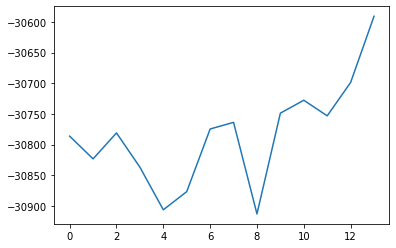

In [475]:
plt.figure()
plt.plot(bic)
print (bic)

# Ok, 9,8 is the thing !

In [67]:
e_model = make_full_model_1D(flat_data,9,8)

Optimization terminated successfully.
         Current function value: -6093.534045
         Iterations: 200
         Function evaluations: 323
Optimization terminated successfully.
         Current function value: -6445.302514
         Iterations: 235
         Function evaluations: 382
Optimization terminated successfully.
         Current function value: -6658.394336
         Iterations: 231
         Function evaluations: 363
Optimization terminated successfully.
         Current function value: -6590.467060
         Iterations: 845
         Function evaluations: 1203
Optimization terminated successfully.
         Current function value: -5964.675766
         Iterations: 882
         Function evaluations: 1252


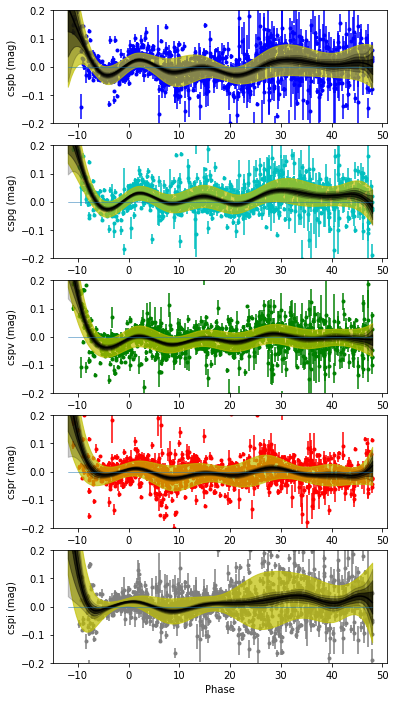

In [68]:
plot_error_model(flat_data,e_model,ylim=0.2)

# Et si on fitte que l'erreur

In [69]:
little_model = make_error_model_1D(flat_data,9,8)

Optimization terminated successfully.
         Current function value: -5958.611833
         Iterations: 987
         Function evaluations: 1392
Optimization terminated successfully.
         Current function value: -6199.377310
         Iterations: 907
         Function evaluations: 1268
Optimization terminated successfully.
         Current function value: -6199.377310
         Iterations: 186
         Function evaluations: 304
Optimization terminated successfully.
         Current function value: -6540.217413
         Iterations: 731
         Function evaluations: 1027
Optimization terminated successfully.
         Current function value: -5889.610958
         Iterations: 208
         Function evaluations: 347


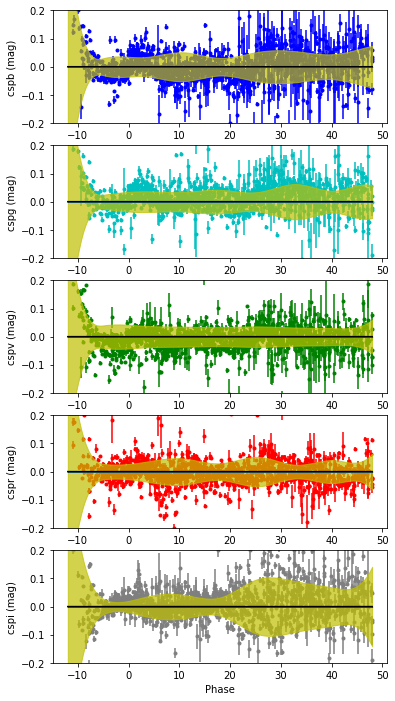

In [70]:
plot_error_model(flat_data,little_model,ylim=0.2)

# OK, robustify

In [78]:
np.std(flat_data['cspb']['residual']-e_model['cspb'].yspl)

0.05417274429817196

(array([  1.,   1.,   1.,   3.,   2.,   3.,  11.,  19.,  69., 184., 436.,
        285., 108.,  43.,  12.,   4.,   3.,   2.,   2.,   2.]),
 array([-0.36272785, -0.32898308, -0.2952383 , -0.26149353, -0.22774875,
        -0.19400398, -0.1602592 , -0.12651443, -0.09276965, -0.05902488,
        -0.0252801 ,  0.00846468,  0.04220945,  0.07595423,  0.109699  ,
         0.14344378,  0.17718855,  0.21093333,  0.2446781 ,  0.27842288,
         0.31216765]),
 <a list of 20 Patch objects>)

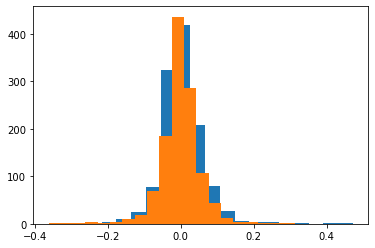

In [81]:
plt.hist(flat_data['cspb']['residual'],bins=20)
plt.hist(flat_data['cspb']['residual']-e_model['cspb'].yspl,bins=20)

1.0070307106987193


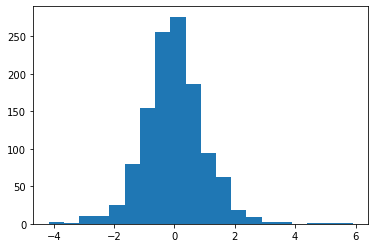

In [83]:
       
sigma = np.sqrt(( flat_data['cspb']['err_mag']**2 + e_model['cspb'].y_model_err**2) )
        
plt.hist((flat_data['cspb']['residual']-e_model['cspb'].yspl)/sigma,bins=20)
print(np.std((flat_data['cspb']['residual']-e_model['cspb'].yspl)/sigma))

In [85]:
nsigma = np.abs((flat_data['cspb']['residual']-e_model['cspb'].yspl)/sigma)

In [95]:
np.sum(nsigma>3)/len(nsigma)

0.010075566750629723

In [103]:
def cumnorm(x):
    return 1/2 *( 1+sc.special.erf(x/np.sqrt(2)) )

In [123]:
( 1 - cumnorm(sorted(-nsigma)))

array([1.        , 0.99999972, 0.99999939, ..., 0.50045131, 0.50037361,
       0.50026682])

(0.0, 0.1)

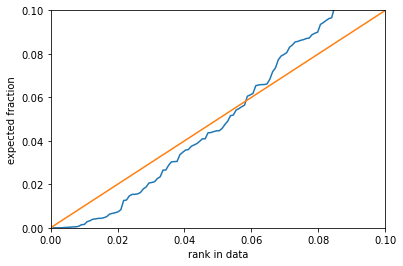

In [131]:
plt.figure()
plt.plot( (np.arange(len(nsigma))+1) / len(nsigma), ( cumnorm(sorted(-nsigma))) *2)
plt.plot((0,1),(0,1))
plt.xlabel('rank in data')
plt.ylabel('expected fraction')
lim = 0.1
plt.xlim(0,lim)
plt.ylim(0,lim)

In [134]:
cumnorm(-2)

0.02275013194817921